Intra Option Q Learning

1. Learning the options simultaneously

In [2]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
from tqdm import tqdm
import random
import gym
import glob
import io
import matplotlib.pyplot as plt

In [3]:
seed = 543
#Setting up the environment
env = gym.make('Taxi-v3')
env.reset(seed=seed)

state_shape = env.observation_space.shape
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print(state,"state")
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print(action)
print("----")

next_state, reward, terminated, truncated, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print(next_state,"nextstate")
print(reward)
print(terminated)
print(truncated)
print(info)
print("----")

()
6
4
----
(328, {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)}) state
----
2
----
348 nextstate
-1
False
False
{'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
----


e:\python\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [4]:
r1_MATRIX = np.array([[0,0,0,0,0],[0,0,0,0,0],[0,3,3,3,3],[1,1,1,1,1],[1,1,1,1,1]])
r1_TERM_MATRIX = np.array([[0,0,0,0,0],[0,0,0,0,0],[1,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]])
r2_MATRIX = np.array([[0,0,0,0,0],[0,0,0,0,0],[2,2,2,2,3],[1,1,1,1,1],[1,1,1,1,1]])
r2_TERM_MATRIX = np.array([[0,0,0,0,0],[0,0,0,0,0],[0,0,0,1,0],[0,0,0,0,0],[0,0,0,0,0]])
OPT_TO_POLICY_MAP = {6 : r1_MATRIX, 7 : r2_MATRIX}
OPT_TO_TERM_MAP = {6 : r1_TERM_MATRIX, 7 : r2_TERM_MATRIX}

In [5]:

def Drive_to_r1(env, state):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = r1_MATRIX[coords[0], coords[1]]

    if (coords == [2, 0]): 
        optdone = True
    
    return [optact, optdone]

def Drive_to_r2(env, state):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = r2_MATRIX[coords[0], coords[1]]
    
    if (coords == [2, 3]):
        optdone = True
    
    return [optact, optdone]

In [6]:
#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
q_values_SMDP = np.zeros((500,8))
R_option_policy=np.zeros((25,4)) # action 6
G_option_policy=np.zeros((25,4)) # action 7 
B_option_policy=np.zeros((25,4)) # action 8 
Y_option_policy=np.zeros((25,4)) # action 9

#Update_Frequency Data structure? Check TODO 4
update_frequency=np.zeros((500,10))
avl_actions = [0, 1, 2, 3, 4, 5, 6, 7]
#avl_actions = [6, 7, 8, 9]
# TODO: epsilon-greedy action selection function
def egreedy_policy_2(q_values,state,epsilon):
  if np.random.rand() < epsilon:
        return np.random.randint(0,4)
  else:
        state_row,state_col,_,_=list(env.decode(state))
        state_no = state_row*5+state_col
        return np.argmax(q_values[state_no])
  
def egreedy_policy(q_values, state, epsilon,disallow,rg):
    if (rg.random() < epsilon):   # epsilon prob for uniform choice over all actions and options
        if (disallow != None):
            val_actions = avl_actions[:]; val_actions.remove(disallow)
            return rg.choice(val_actions)
        else:
            return rg.choice(avl_actions)
    else:                         # 1 - epsilon prob for greedy action/option
            return np.argmax(q_values[state])
    

In [7]:
def learn_R1(env, state,q):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = egreedy_policy_2(q,state,0.9)
    if (coords == [2, 0]): # termination at reaching RED
        optdone = True
    return [optact, optdone]

def learn_R2(env, state,q):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = egreedy_policy_2(q,state,0.9)
    if (coords == [2, 3]): # termination at reaching RED
        optdone = True
    return [optact, optdone]




In [12]:
def ioql_cus(alpha,epsilon):
   

    # Initialize episode_rewards list to store rewards obtained during each episode
    episode_rewards = []
    
    # Add parameters you might need here
    gamma = 0.9
    q_values_SMDP = np.zeros((500,8))
    R_option_policy=np.zeros((25,4)) # action 6
    G_option_policy=np.zeros((25,4)) # action 7 
    B_option_policy=np.zeros((25,4)) # action 8 
    Y_option_policy=np.zeros((25,4)) # action 9


    # Iterate over 1000 episodes
    for _ in tqdm(range(5000)):
        
        state, _ = env.reset()   
        #print(state)
        done = False
        total_reward = 0  # Initialize total reward for the episode

        # While episode is not over
        while not done:
        
            
            # Choose action  
            st_coords = tuple(env.decode(state))[:2]
            
            dis_opts = {(0,0) : 6, (0,4) : 7, (4,0) : 8, (4,3) : 9} 
            dis_opt = (dis_opts[st_coords] if st_coords in dis_opts.keys() else None) 
            action = egreedy_policy(q_values_SMDP, state, epsilon, dis_opt,rg= np.random.RandomState(42))   
            #print(action,st_coords,"hello")
            #action = egreedy_policy(q_values_SMDP, state, epsilon)
            # Checking if primitive action
            if action < 6:
                # Perform regular Q-Learning update for state-action pair
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                
                q_values_SMDP[state][action] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state][action])
                update_frequency[state][action] += 1
                
                state = next_state
                total_reward += reward  # Accumulate reward for the episode
            
            # Checking if action chosen is an option
            reward_bar = 0
            s_state = state
            if action == 6: # action => Away option
                k = 0
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                optdone = False
                while not optdone:
                    k += 1
                    state_no=state_row*5+state_col
                    optact, optdone = learn_R1(env, state,R_option_policy) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    state_row,state_col,_,_=list(env.decode(next_state))
                    next_state_no=state_row*5+state_col
                    q_values_SMDP[state, optact] += alpha * (reward + gamma*np.max(q_values_SMDP[next_state]) - q_values_SMDP[state, optact])
                    update_frequency[state, optact] += 1
                    R_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                    options_to_update = [action]
                    st_coords = list(env.decode(state))[:2]
                    other_options = [7,]
                    for oth in other_options:
                        if oth == 7:
                            pa,pd = learn_R2(env,state,G_option_policy)
                            if pa == optact:
                                options_to_update.append(oth)
                    
                    nst_coords = list(env.decode(next_state))[:2]
                    for opt in options_to_update:
                            term_matrix = OPT_TO_TERM_MAP[opt]
                            if term_matrix[nst_coords[0], nst_coords[1]] == 1:
                                # if the option terminates, we do total max over all actions(and options) in next state
                                q_values_SMDP[state, opt] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state, opt])
                                update_frequency[state, opt] += 1
                            else:
                                # if it does not, we use the option q-value in next state for update
                                q_values_SMDP[state, opt] += alpha * (reward + gamma * (q_values_SMDP[next_state, opt]) - q_values_SMDP[state, opt])
                                update_frequency[state, opt] += 1
                    state = next_state

                    reward_bar = gamma * reward_bar + reward
                    state_row,state_col,_,_=list(env.decode(state))
                    pos=[state_row,state_col]
                    
                #q_values_SMDP[s_state][6] += alpha * (reward_bar + (gamma ** k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][6])
                #update_frequency[state][6] += 1
                total_reward += reward_bar  # Accumulate reward for the episode

            # Update state for other option actions (similar to action 6)
            if action == 7: # action => Away option
                k = 0
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                optdone = False
                while not optdone:
                    k += 1
                    state_no=state_row*5+state_col
                    optact, optdone = learn_R2(env, state,R_option_policy) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    state_row,state_col,_,_=list(env.decode(next_state))
                    next_state_no=state_row*5+state_col
                    q_values_SMDP[state, optact] += alpha * (reward + gamma*np.max(q_values_SMDP[next_state]) - q_values_SMDP[state, optact])
                    update_frequency[state, optact] += 1
                    R_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                    options_to_update = [action]
                    st_coords = list(env.decode(state))[:2]
                    other_options = [6]
                    for oth in other_options:
                        if oth == 6:
                            pa,pd = learn_R1(env,state,G_option_policy)
                            if pa == optact:
                                options_to_update.append(oth)
                    nst_coords = list(env.decode(next_state))[:2]
                    for opt in options_to_update:
                            term_matrix = OPT_TO_TERM_MAP[opt]
                            if term_matrix[nst_coords[0], nst_coords[1]] == 1:
                                # if the option terminates, we do total max over all actions(and options) in next state
                                q_values_SMDP[state, opt] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state, opt])
                                update_frequency[state, opt] += 1
                            else:
                                # if it does not, we use the option q-value in next state for update
                                q_values_SMDP[state, opt] += alpha * (reward + gamma * (q_values_SMDP[next_state, opt]) - q_values_SMDP[state, opt])
                                update_frequency[state, opt] += 1
                    state = next_state

                    reward_bar = gamma * reward_bar + reward
                    state_row,state_col,_,_=list(env.decode(state))
                    pos=[state_row,state_col]
                    
                #q_values_SMDP[s_state][6] += alpha * (reward_bar + (gamma ** k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][6])
                #update_frequency[state][6] += 1
                total_reward += reward_bar  # Accumulate reward for the episode


            # Check if episode is done
            if done:
                episode_rewards.append(total_reward)  # Append total reward for the episode

    # Plot rewards vs. episodes
    return sum(episode_rewards)


        

  0%|          | 0/500000 [00:00<?, ?it/s]

100%|██████████| 500000/500000 [26:13<00:00, 317.66it/s]


In [13]:
from bayes_opt import BayesianOptimization
param_space = {
   
    'alpha': (0.1, 0.7),
    'epsilon': (0.02, 0.25),
}
optimizer = BayesianOptimization(
    f=ioql_cus,
    pbounds=param_space,
    random_state=1,
)
optimizer.maximize(
    init_points=5,
    n_iter=15,
)

|   iter    |  target   |   alpha   |  epsilon  |
-------------------------------------------------


100%|██████████| 5000/5000 [00:15<00:00, 322.69it/s]


| 1         | 5.755e+03 | 0.3502    | 0.1857    |


100%|██████████| 5000/5000 [00:22<00:00, 226.34it/s]


| 2         | -5.664e+0 | 0.1001    | 0.08954   |


100%|██████████| 5000/5000 [00:17<00:00, 279.89it/s]


| 3         | -1.73e+04 | 0.1881    | 0.04124   |


100%|██████████| 5000/5000 [00:17<00:00, 285.34it/s]


| 4         | -1.068e+0 | 0.2118    | 0.09948   |


100%|██████████| 5000/5000 [00:15<00:00, 331.82it/s]


| 5         | 5.444e+03 | 0.3381    | 0.1439    |


100%|██████████| 5000/5000 [00:15<00:00, 316.50it/s]


| 6         | 1.233e+04 | 0.5205    | 0.1435    |


100%|██████████| 5000/5000 [00:13<00:00, 357.65it/s]


| 7         | 1.794e+04 | 0.6662    | 0.25      |


100%|██████████| 5000/5000 [00:17<00:00, 279.28it/s]


| 8         | -1.745e+0 | 0.1896    | 0.1646    |


100%|██████████| 5000/5000 [00:13<00:00, 368.36it/s]


| 9         | 1.696e+04 | 0.7       | 0.04997   |


100%|██████████| 5000/5000 [00:14<00:00, 353.40it/s]


| 10        | 1.334e+04 | 0.5458    | 0.02      |


100%|██████████| 5000/5000 [00:13<00:00, 359.76it/s]


| 11        | 1.804e+04 | 0.7       | 0.1577    |


100%|██████████| 5000/5000 [00:14<00:00, 347.27it/s]


| 12        | 1.185e+04 | 0.5313    | 0.25      |


100%|██████████| 5000/5000 [00:14<00:00, 334.91it/s]


| 13        | 5.565e+03 | 0.3917    | 0.02      |


100%|██████████| 5000/5000 [00:13<00:00, 363.75it/s]


| 14        | 1.504e+04 | 0.6245    | 0.1173    |


100%|██████████| 5000/5000 [00:16<00:00, 300.82it/s]


| 15        | -1.463e+0 | 0.1891    | 0.1135    |


100%|██████████| 5000/5000 [00:13<00:00, 364.50it/s]


| 16        | 1.225e+04 | 0.6355    | 0.02      |


100%|██████████| 5000/5000 [00:13<00:00, 379.42it/s]


| 17        | 1.65e+04  | 0.6977    | 0.16      |


100%|██████████| 5000/5000 [00:13<00:00, 363.68it/s]


| 18        | 7.634e+03 | 0.4342    | 0.25      |


100%|██████████| 5000/5000 [00:13<00:00, 364.94it/s]


| 19        | 9.073e+03 | 0.4386    | 0.1096    |


100%|██████████| 5000/5000 [00:12<00:00, 389.93it/s]

| 20        | 1.751e+04 | 0.698     | 0.1028    |


In [14]:
print(optimizer.max)

{'target': 18038.57484058183, 'params': {'alpha': 0.7, 'epsilon': 0.1576793782759692}}


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # tqdm is a library for displaying progress bars

# Initialize episode_rewards list to store rewards obtained during each episode
episode_rewards = []

# Add parameters you might need here
gamma = 0.9
alpha =  optimizer.max["params"]["alpha"]
epsilon =  optimizer.max["params"]["epsilon"]
q_values_SMDP = np.zeros((500,8))
R_option_policy=np.zeros((25,4)) # action 6
G_option_policy=np.zeros((25,4)) # action 7 
B_option_policy=np.zeros((25,4)) # action 8 
Y_option_policy=np.zeros((25,4)) # action 9
# Iterate over 1000 episodes

# Iterate over 1000 episodes
for _ in tqdm(range(500000)):
    
    state, _ = env.reset()   
    #print(state)
    done = False
    total_reward = 0  # Initialize total reward for the episode

    # While episode is not over
    while not done:
       
        
        # Choose action  
        st_coords = tuple(env.decode(state))[:2]
        
        dis_opts = {(0,0) : 6, (0,4) : 7, (4,0) : 8, (4,3) : 9} 
        dis_opt = (dis_opts[st_coords] if st_coords in dis_opts.keys() else None) 
        action = egreedy_policy(q_values_SMDP, state, epsilon, dis_opt,rg= np.random.RandomState(42))   
        #print(action,st_coords,"hello")
        #action = egreedy_policy(q_values_SMDP, state, epsilon)
        # Checking if primitive action
        if action < 6:
            # Perform regular Q-Learning update for state-action pair
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            q_values_SMDP[state][action] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state][action])
            update_frequency[state][action] += 1
            
            state = next_state
            total_reward += reward  # Accumulate reward for the episode
        
        # Checking if action chosen is an option
        reward_bar = 0
        s_state = state
        if action == 6: # action => Away option
            k = 0
            state_row,state_col,_,_=list(env.decode(state))
            pos=[state_row,state_col]
            optdone = False
            while not optdone:
                k += 1
                state_no=state_row*5+state_col
                optact, optdone = learn_R1(env, state,R_option_policy) 
                next_state, reward, terminated, truncated, info = env.step(optact)
                done = terminated or truncated
                state_row,state_col,_,_=list(env.decode(next_state))
                next_state_no=state_row*5+state_col
                q_values_SMDP[state, optact] += alpha * (reward + gamma*np.max(q_values_SMDP[next_state]) - q_values_SMDP[state, optact])
                update_frequency[state, optact] += 1
                R_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                options_to_update = [action]
                st_coords = list(env.decode(state))[:2]
                other_options = [7,]
                for oth in other_options:
                    if oth == 7:
                        pa,pd = learn_R2(env,state,G_option_policy)
                        if pa == optact:
                            options_to_update.append(oth)
                   
                nst_coords = list(env.decode(next_state))[:2]
                for opt in options_to_update:
                        term_matrix = OPT_TO_TERM_MAP[opt]
                        if term_matrix[nst_coords[0], nst_coords[1]] == 1:
                            # if the option terminates, we do total max over all actions(and options) in next state
                            q_values_SMDP[state, opt] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state, opt])
                            update_frequency[state, opt] += 1
                        else:
                            # if it does not, we use the option q-value in next state for update
                            q_values_SMDP[state, opt] += alpha * (reward + gamma * (q_values_SMDP[next_state, opt]) - q_values_SMDP[state, opt])
                            update_frequency[state, opt] += 1
                state = next_state

                reward_bar = gamma * reward_bar + reward
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                
            #q_values_SMDP[s_state][6] += alpha * (reward_bar + (gamma ** k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][6])
            #update_frequency[state][6] += 1
            total_reward += reward_bar  # Accumulate reward for the episode

        # Update state for other option actions (similar to action 6)
        if action == 7: # action => Away option
            k = 0
            state_row,state_col,_,_=list(env.decode(state))
            pos=[state_row,state_col]
            optdone = False
            while not optdone:
                k += 1
                state_no=state_row*5+state_col
                optact, optdone = learn_R2(env, state,R_option_policy) 
                next_state, reward, terminated, truncated, info = env.step(optact)
                done = terminated or truncated
                state_row,state_col,_,_=list(env.decode(next_state))
                next_state_no=state_row*5+state_col
                q_values_SMDP[state, optact] += alpha * (reward + gamma*np.max(q_values_SMDP[next_state]) - q_values_SMDP[state, optact])
                update_frequency[state, optact] += 1
                R_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                options_to_update = [action]
                st_coords = list(env.decode(state))[:2]
                other_options = [6]
                for oth in other_options:
                    if oth == 6:
                        pa,pd = learn_R1(env,state,G_option_policy)
                        if pa == optact:
                            options_to_update.append(oth)
                nst_coords = list(env.decode(next_state))[:2]
                for opt in options_to_update:
                        term_matrix = OPT_TO_TERM_MAP[opt]
                        if term_matrix[nst_coords[0], nst_coords[1]] == 1:
                            # if the option terminates, we do total max over all actions(and options) in next state
                            q_values_SMDP[state, opt] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state, opt])
                            update_frequency[state, opt] += 1
                        else:
                            # if it does not, we use the option q-value in next state for update
                            q_values_SMDP[state, opt] += alpha * (reward + gamma * (q_values_SMDP[next_state, opt]) - q_values_SMDP[state, opt])
                            update_frequency[state, opt] += 1
                state = next_state

                reward_bar = gamma * reward_bar + reward
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                
            #q_values_SMDP[s_state][6] += alpha * (reward_bar + (gamma ** k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][6])
            #update_frequency[state][6] += 1
            total_reward += reward_bar  # Accumulate reward for the episode


        # Check if episode is done
        if done:
            episode_rewards.append(total_reward)  # Append total reward for the episode

# Plot rewards vs. episodes



        

100%|██████████| 500000/500000 [22:08<00:00, 376.50it/s]


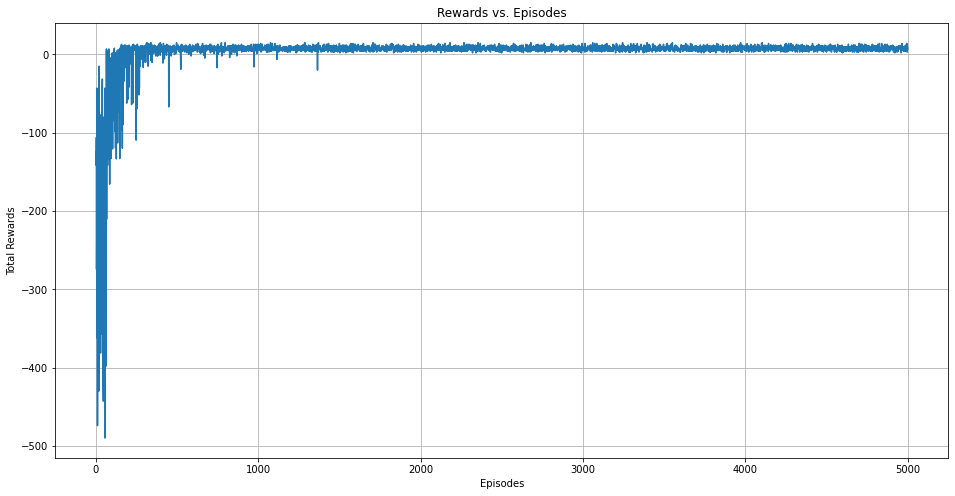

In [25]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(range(1,5000 + 1), episode_rewards[:5000])

plt.xlabel('Episodes')

plt.ylabel('Total Rewards')
plt.title('Rewards vs. Episodes')
plt.grid(True)
plt.show()

In [17]:
def visualize_q_values(q_values, msg, pass_src = None, pass_dest = None):
    assert(pass_src != None and pass_dest != None)

    req_actions = [[None for _ in range(5)] for _ in range(5)]
    req_q_values = [[None for _ in range(5)] for _ in range(5)]
    temp_env = gym.make('Taxi-v3')
    for s in range(500):
        s_vec = list(temp_env.decode(s))
        if s_vec[2] == pass_src and s_vec[3] == pass_dest:
            req_actions[s_vec[0]][s_vec[1]] = np.argmax(q_values[s])
            req_q_values[s_vec[0]][s_vec[1]] = np.max(q_values[s])
    req_actions = np.array(req_actions)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title(msg)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xlabel('Columns')
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Rows')
    mesh = ax.pcolormesh(req_q_values, edgecolors='k', linewidths=2)
    fig.colorbar(mesh)
    def x_direct(a):
        if a in [4,5,6,7,8]:
            return 0
        if a in [0, 1]:
            return 0
        return 1 if a == 2 else -1
    def y_direct(a):
        if a in [4,5,6,7,8]:
            return 0
        if a in [2, 3]:
            return 0
        return 1 if a == 1 else -1
    idx = np.indices((5,5))
    policyx = np.vectorize(x_direct)(req_actions)
    policyy = np.vectorize(y_direct)(req_actions)
    req_action_dict = {4 : 'Pickup', 5 : 'Drop', 6 : 'R', 7 : 'G', 8 : 'Y', 9 : 'B'}
    for i,j,px,py in zip(idx[1].ravel(), idx[0].ravel(), policyx.ravel(), policyy.ravel()):
        if (req_actions[j, i] < 4):
            ax.quiver(i+0.5, j+0.5, px, py, pivot="middle", scale=10,color='red')
        else:
            ax.text(i+0.5, j+0.5, req_action_dict[req_actions[j][i]], horizontalalignment='center',verticalalignment='center',color='tomato')
    

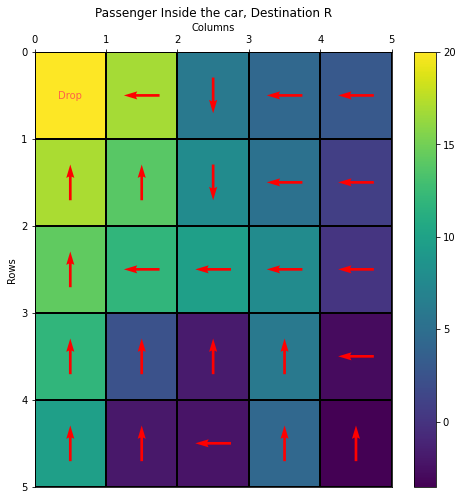

In [18]:
visualize_q_values(q_values_SMDP, "Passenger Inside the car, Destination R", 4, 0)

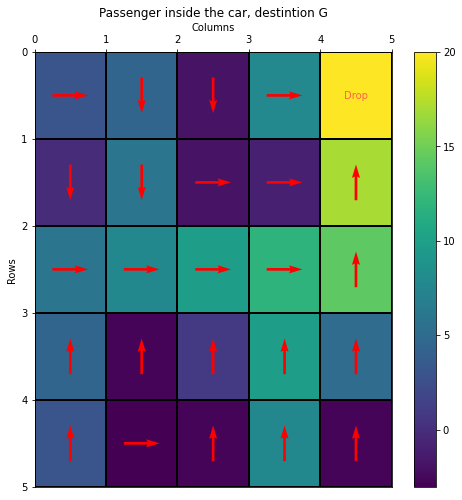

In [19]:
visualize_q_values(q_values_SMDP, "Passenger inside the car, destintion G",  4, 1)

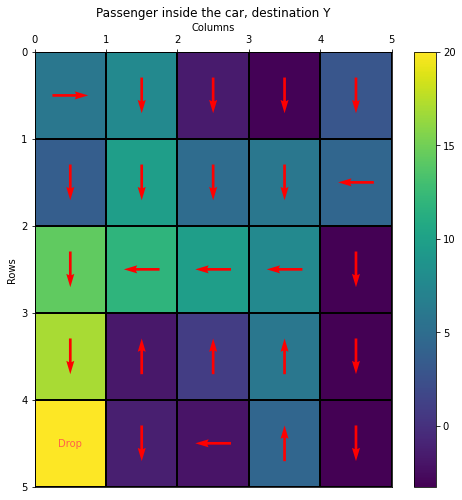

In [20]:
visualize_q_values(q_values_SMDP, "Passenger inside the car, destination Y",  4, 2)


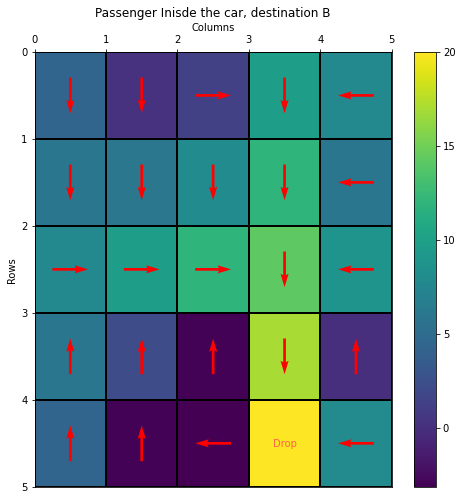

In [21]:
visualize_q_values(q_values_SMDP, "Passenger Inisde the car, destination B",  4, 3)

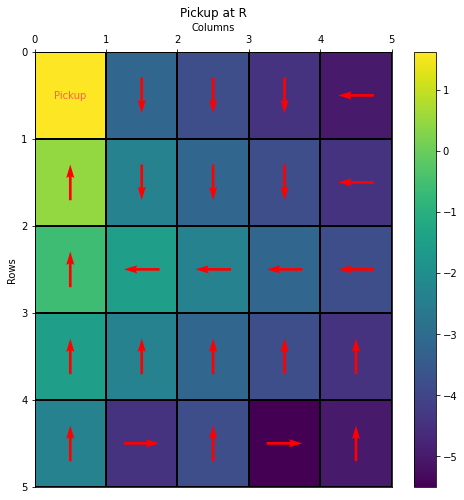

In [22]:
visualize_q_values(q_values_SMDP, "Pickup at R",  0, 1)

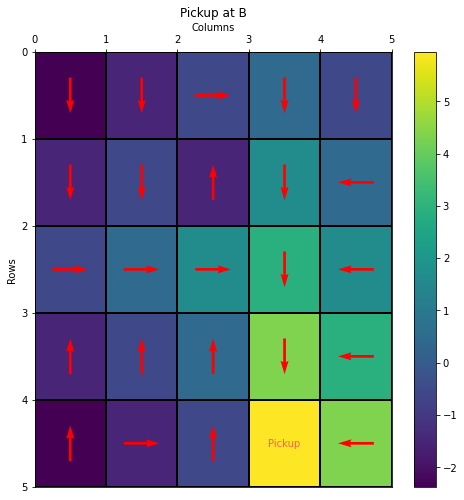

In [23]:
visualize_q_values(q_values_SMDP, "Pickup at B",  3, 1)

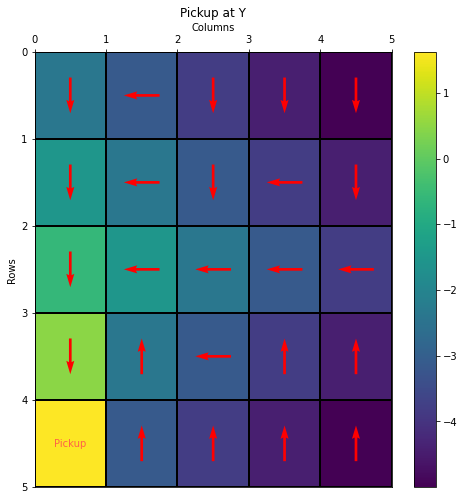

In [24]:
visualize_q_values(q_values_SMDP, "Pickup at Y", 2, 1)